In [6]:
# from google.colab import drive
# a=drive.mount('fashion-mnist_train.csv')
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import math;
import random
random.seed(1)
import pandas as pd
import io
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
id= '1lCitzZfhJ8s1tGTXtQhA9IV1oF-zJjqC'
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('fashion-mnist_train.csv') 
data = pd.read_csv('fashion-mnist_train.csv')


In [8]:
import numpy as np
import math
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets
import matplotlib.pyplot as plt


In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyper-parameters
input_size = 784 # 28x28
hidden_size = 500
num_classes = 10
num_epochs = 15
batch_size = 128
learning_rate = 0.0001

In [19]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
train=True,
transform=transforms.ToTensor(),
download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
train=False,
transform=transforms.ToTensor(),
download=True)
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
batch_size=batch_size,
shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
batch_size=batch_size,
shuffle=False)
###########################################
def create_datasets(batch_size):
# percentage of training set to use as validation
  valid_size = 0.2
# convert data to torch.FloatTensor
  transform = transforms.ToTensor()
# choose the training and test datasets
  train_data = datasets.MNIST(root='data',
  train=True,
  download=True,
  transform=transform)
  test_data = datasets.MNIST(root='data',
  train=False,
  download=True,
  transform=transform)
  # obtain training indices that will be used for validation
  num_train = len(train_data)
  indices = list(range(num_train))
  np.random.shuffle(indices)
  split = int(np.floor(valid_size * num_train))
  train_idx, valid_idx = indices[split:], indices[:split]
  # define samplers for obtaining training and validation batches
  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  # load training data in batches
  train_loader = torch.utils.data.DataLoader(train_data,
  batch_size=batch_size,
  sampler=train_sampler,
  num_workers=0)
  # load validation data in batches
  valid_loader = torch.utils.data.DataLoader(train_data,
  batch_size=batch_size,
  sampler=valid_sampler,
  num_workers=0)
  # load test data in batches
  test_loader = torch.utils.data.DataLoader(test_data,
  batch_size=batch_size,
  num_workers=0)
  return train_loader, test_loader, valid_loader

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

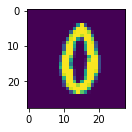

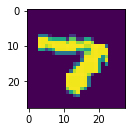

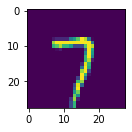

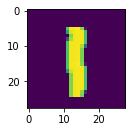

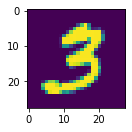

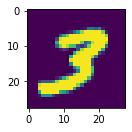

In [52]:
examples = iter(train_loader)
example_data, example_targets = examples.next()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.imshow(example_data[i][0])
  plt.show()
#example_data[1][0]


In [53]:
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.input_size = input_size
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, math.floor(hidden_size/2))
    self.l3 = nn.Linear(math.floor(hidden_size/2), num_classes)
    self.N=nn.Softmax()
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out = self.l2(out)
    out = self.relu(out)
    out = self.l3(out)
    # no activation and no softmax at the end
    return out
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)


NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=250, bias=True)
  (l3): Linear(in_features=250, out_features=10, bias=True)
  (N): Softmax(dim=None)
)


Epoch [1/15], Step [200/375], Loss: 0.0631847009062767
Epoch [2/15], Step [200/375], Loss: 0.012800504453480244
Epoch [3/15], Step [200/375], Loss: 0.03503318876028061
Epoch [4/15], Step [200/375], Loss: 0.014429392293095589
Epoch [5/15], Step [200/375], Loss: 0.01509117428213358
Epoch [6/15], Step [200/375], Loss: 0.003785206936299801
Epoch [7/15], Step [200/375], Loss: 0.00901369284838438
Epoch [8/15], Step [200/375], Loss: 0.005719271954149008
Epoch [9/15], Step [200/375], Loss: 0.011730830185115337
Epoch [10/15], Step [200/375], Loss: 0.01411798782646656
Epoch [11/15], Step [200/375], Loss: 0.007466709241271019
Epoch [12/15], Step [200/375], Loss: 0.006161957513540983
Epoch [13/15], Step [200/375], Loss: 0.01774677075445652
Epoch [14/15], Step [200/375], Loss: 0.00403959583491087
Epoch [15/15], Step [200/375], Loss: 0.0019741314463317394


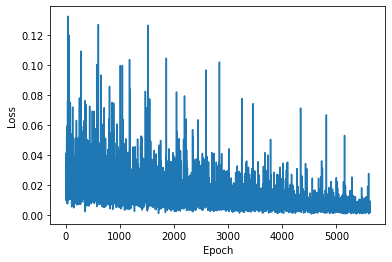

In [59]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)
Loss=[]
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [100, 1, 28, 28]
    # resized: [100, 784]
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Loss.append(loss.item())
    if (i+1) % 200 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')

plt.plot(Loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [60]:
# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 98.12 %


In [61]:
del model
class NeuralNet(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(NeuralNet, self).__init__()
    self.input_size = input_size
    self.l1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.l2 = nn.Linear(hidden_size, math.floor(hidden_size/2))
    self.BN= nn.BatchNorm1d(math.floor(hidden_size/2))
    self.D0=nn.Dropout(0.05)
    self.D1=nn.Dropout(0.15)
    self.l3 = nn.Linear(math.floor(hidden_size/2), num_classes*2)
    self.BN2= nn.BatchNorm1d(num_classes*2)
    self.l4 = nn.Linear(num_classes*2, num_classes)
    self.N=nn.Softmax()
  def forward(self, x):
    out = self.l1(x)
    out = self.relu(out)
    out= self.D0(out)
    out = self.l2(out)
    out= self.BN(out)
    out = self.relu(out)
    out= self.D1(out)
    out = self.l3(out)
    out = self.relu(out)
    out= self.BN2(out)
    out = self.relu(out)
    out = self.l4(out)
    # no activation and no softmax at the end
    return out
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
print(model)


NeuralNet(
  (l1): Linear(in_features=784, out_features=500, bias=True)
  (relu): ReLU()
  (l2): Linear(in_features=500, out_features=250, bias=True)
  (BN): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (D0): Dropout(p=0.05, inplace=False)
  (D1): Dropout(p=0.15, inplace=False)
  (l3): Linear(in_features=250, out_features=20, bias=True)
  (BN2): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l4): Linear(in_features=20, out_features=10, bias=True)
  (N): Softmax(dim=None)
)


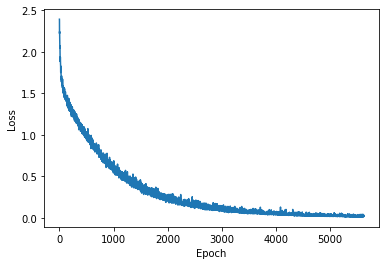

In [62]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)
Loss2=[]
n_total_steps = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [100, 1, 28, 28]
    # resized: [100, 784]
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
    outputsval = model(images)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    Loss2.append(loss.item())
  if (i+1) % 200 == 0:
    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item()}')
plt.plot(Loss2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [63]:
 # Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  for images, labels in test_loader:
    images = images.reshape(-1, 28*28).to(device)
    labels = labels.to(device)
    outputs = model(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs.data, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()
  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network on the 10000 test images: {acc} %')

Accuracy of the network on the 10000 test images: 97.99 %


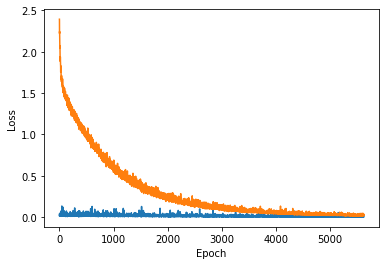

In [64]:
plt.plot(Loss)
plt.plot(Loss2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


In [95]:
del model
model = NeuralNet(input_size, hidden_size, num_classes).to(device)
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.00001)


In [79]:
!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 798 kB 6.8 MB/s 
     |████████████████████████████████| 529 kB 61.4 MB/s 
     |████████████████████████████████| 87 kB 6.0 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115940 sha256=b1c25bc816d36f52e5d52b76e92bfbed4c0a44a377e85fd666d855a2a3329f37
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [108]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorchtools import EarlyStopping

ImportError: ignored

In [106]:
def train_model(model, batch_size, patience, n_epochs):
  # to track the training loss as the model trains
  train_losses = []
  # to track the validation loss as the model trains
  valid_losses = []
  # to track the average training loss per epoch as the model trains
  avg_train_losses = []
  # to track the average validation loss per epoch as the model trains
  avg_valid_losses = []
  # initialize the early_stopping object
  early_stopping = EarlyStopping(patience=patience, verbose=True,monitor="val_loss")
  for epoch in range( n_epochs ):
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    #for i, (images, labels) in enumerate(train_loader):
    for batch, (data, target) in enumerate(train_loader,1):
      # clear the gradients of all optimized variables
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)
      optimizer.zero_grad()
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # backward pass: compute gradient of the loss with respect to model parameters
      loss.backward()
      # perform a single optimization step (parameter update)
      optimizer.step()
      # record training loss
      train_losses.append(loss.item())
    ######################
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in valid_loader:
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(data)
      # calculate the loss
      loss = criterion(output, target)
      # record validation loss
      valid_losses.append(loss.item())
    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)
    epoch_len = len(str(n_epochs))
    print_msg = (f'[{epoch:>{epoch_len+1}}/{n_epochs:>{epoch_len}}] ' +
    f'train_loss: {train_loss:.5f} ' +
    f'valid_loss: {valid_loss:.5f}')
    print(print_msg)
    # clear lists to track next epoch
    train_losses = []
    valid_losses = []
    # early_stopping needs the validation loss to check if it has decresed,
    # and if it has, it will make a checkpoint of the current model
    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break
  # load the last checkpoint with the best model
  model.load_state_dict(torch.load('checkpoint.pt'))
  return model, avg_train_losses, avg_valid_losses


In [107]:
batch_size = batch_size
n_epochs = num_epochs+10
train_loader, test_loader, valid_loader = create_datasets(batch_size)
# early stopping patience; how long to wait after last time validation loss improved.
patience = 20
model, train_loss, valid_loss = train_model(model, batch_size, patience, n_epochs)


[  0/25] train_loss: 0.43005 valid_loss: 0.33309


TypeError: ignored

In [102]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')
# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 1) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

NameError: ignored

<Figure size 720x576 with 0 Axes>

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation
for data, target in test_loader:
  if len(target.data) != batch_size:
    break
  data = data.reshape(-1, 28*28).to(device)
  target = target.to(device)
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  # calculate the loss
  loss = criterion(output, target)
  # update test loss
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)
  # compare predictions to true label
  correct = np.squeeze(pred.eq(target.data.view_as(pred)))
  # calculate test accuracy for each object class
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1
# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(10):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
    str(i), 100 * class_correct[i] / class_total[i],
    np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
print('\nTest Accuracy (Overall): %5d%% (%5d/%5d)' % (100. * np.sum(class_correct) / np.sum(class_total),
                                                      np.sum(class_correct), np.sum(class_total)))
